In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import itertools
import cv2
from PIL import Image
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical
from keras_tuner import RandomSearch
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
test_file_path = "../../Dataset/FER2013/test"
train_file_path = "../../Dataset/FER2013/train"

In [3]:
def preprocess_image(image):
    image = Image.fromarray(image.squeeze())  # Remove color channels for grayscale
    image = image.resize((64, 64), Image.BILINEAR)  # Resize to 64x64
    return np.expand_dims(np.array(image), axis=-1) 

In [4]:
augment_parameter = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function = preprocess_image,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_image)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_image)

In [11]:
# train_generator = augment_parameter.flow_from_directory(
#    train_file_path,
#    target_size=(64, 64),  # or any size that your model expects
#    batch_size=32,
#    class_mode='categorical',
#    color_mode='grayscale')

train_generator = train_datagen.flow_from_directory(
     train_file_path,
     target_size=(64, 64),  # or any size that your model expects
     batch_size=32,
     class_mode='categorical',
     color_mode='grayscale')

test_generator = test_datagen.flow_from_directory(
    test_file_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [69]:
def build_simplified_model(conv_1_filters, conv_2_filters, 
                           conv_1_kernel, conv_2_kernel,
                           dropout_1, dropout_2, dense_units, optimizer):
    model = Sequential()
    model.add(Conv2D(conv_1_filters, kernel_size=conv_1_kernel, activation='relu', input_shape=(64,64,1)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(dropout_1))

    model.add(Conv2D(conv_2_filters, kernel_size=conv_2_kernel, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(dropout_2))

    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

# First Attempt

In [83]:
from tensorflow.keras.optimizers import Adam

model_basic = build_simplified_model(
    conv_1_filters=32, conv_2_filters=64, 
    conv_1_kernel=3, conv_2_kernel=3, 
    dropout_1=0.5, dropout_2=0.6, 
    dense_units=1024, 
    optimizer= Adam(learning_rate=0.0001) 
)

history_v1 = model_basic.fit(train_generator, validation_data=test_generator, epochs=15, callbacks=[early_stopping])

Epoch 1/15
898/898 [==============================] - 122s 135ms/step - loss: 1.7612 - accuracy: 0.2863 - val_loss: 1.7160 - val_accuracy: 0.3650
Epoch 2/15
898/898 [==============================] - 126s 141ms/step - loss: 1.6239 - accuracy: 0.3693 - val_loss: 1.6150 - val_accuracy: 0.4085
Epoch 3/15
898/898 [==============================] - 124s 138ms/step - loss: 1.5643 - accuracy: 0.3983 - val_loss: 1.5441 - val_accuracy: 0.4167
Epoch 4/15
898/898 [==============================] - 130s 144ms/step - loss: 1.5170 - accuracy: 0.4184 - val_loss: 1.4958 - val_accuracy: 0.4376
Epoch 5/15
898/898 [==============================] - 134s 149ms/step - loss: 1.4706 - accuracy: 0.4331 - val_loss: 1.4427 - val_accuracy: 0.4469
Epoch 6/15
898/898 [==============================] - 127s 142ms/step - loss: 1.4256 - accuracy: 0.4539 - val_loss: 1.3976 - val_accuracy: 0.4710
Epoch 7/15
898/898 [==============================] - 132s 147ms/step - loss: 1.3853 - accuracy: 0.4700 - val_loss: 1.3665 -

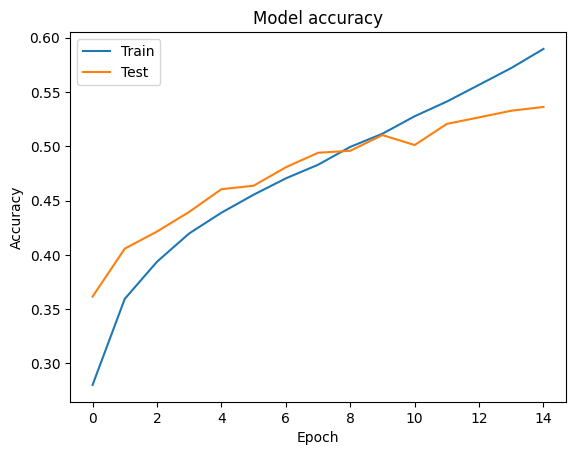

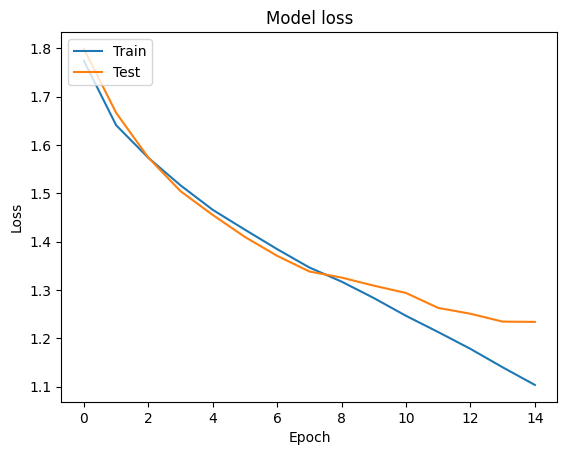

In [76]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_v1.history['accuracy'])
plt.plot(history_v1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_v1.history['loss'])
plt.plot(history_v1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
def build_complex_model(conv_1_filters, conv_2_filters, 
                           conv_1_kernel, conv_2_kernel,
                           dropout_1, dropout_2, dense_units, optimizer):
    model = Sequential()
    model.add(Conv2D(conv_1_filters, kernel_size=conv_1_kernel, activation='relu', input_shape=(64,64,1)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(dropout_1))

    model.add(Conv2D(conv_1_filters, kernel_size=conv_1_kernel, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(dropout_1))

    model.add(Conv2D(conv_2_filters, kernel_size=conv_2_kernel, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(dropout_2))

    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
from tensorflow.keras.optimizers import Adam

model = build_complex_model(
    conv_1_filters=32, conv_2_filters=64, 
    conv_1_kernel=3, conv_2_kernel=3, 
    dropout_1=0.5, dropout_2=0.6, 
    dense_units=1024, 
    optimizer= Adam(learning_rate=0.0001) 
)

history_v1 = model.fit(train_generator, validation_data=test_generator, epochs=140, callbacks=[early_stopping])

Epoch 1/140
898/898 [==============================] - 58s 63ms/step - loss: 1.8204 - accuracy: 0.2447 - val_loss: 1.8892 - val_accuracy: 0.2607
Epoch 2/140
898/898 [==============================] - 62s 69ms/step - loss: 1.7686 - accuracy: 0.2755 - val_loss: 1.8163 - val_accuracy: 0.2604
Epoch 3/140
898/898 [==============================] - 64s 71ms/step - loss: 1.7088 - accuracy: 0.3155 - val_loss: 1.7524 - val_accuracy: 0.3094
Epoch 4/140
898/898 [==============================] - 60s 67ms/step - loss: 1.6614 - accuracy: 0.3427 - val_loss: 1.6985 - val_accuracy: 0.3566
Epoch 5/140
898/898 [==============================] - 62s 69ms/step - loss: 1.6248 - accuracy: 0.3642 - val_loss: 1.6436 - val_accuracy: 0.3904
Epoch 6/140
898/898 [==============================] - 61s 68ms/step - loss: 1.5948 - accuracy: 0.3803 - val_loss: 1.6068 - val_accuracy: 0.3986
Epoch 7/140
898/898 [==============================] - 58s 64ms/step - loss: 1.5652 - accuracy: 0.3934 - val_loss: 1.5451 - val_ac

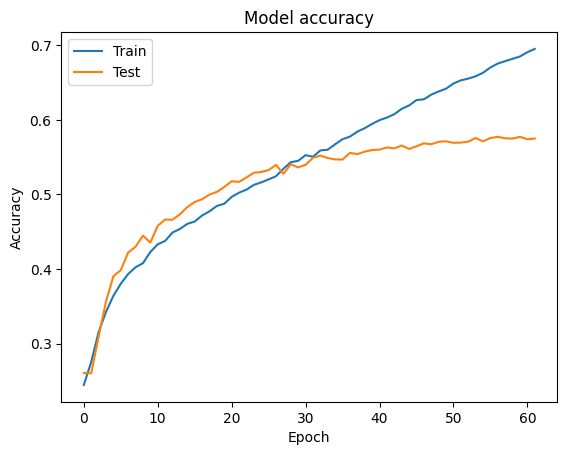

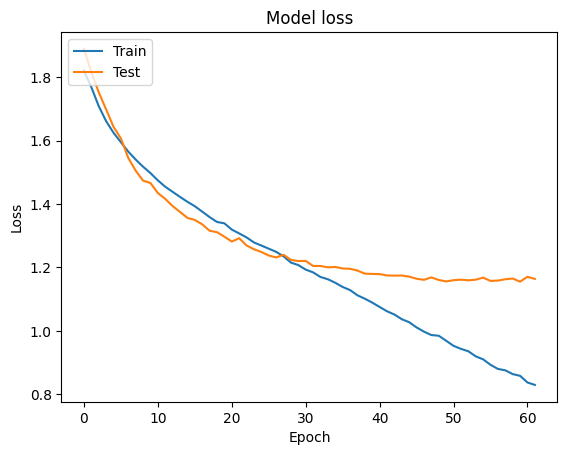

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history_v1.history['accuracy'])
plt.plot(history_v1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_v1.history['loss'])
plt.plot(history_v1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Second Attempt (with Class Weight)

In [130]:
class_dirs = sorted([d for d in os.listdir(train_file_path) if os.path.isdir(os.path.join(train_file_path, d))])
class_counts = {}

# Count the number of samples in each class
for class_dir in class_dirs:
    class_path = os.path.join(train_file_path, class_dir)
    class_counts[class_dir] = len(os.listdir(class_path))

# Calculate total samples and class weights
total_samples = sum(class_counts.values())
class_weights = {class_idx: total_samples / (len(class_dirs) * count)
                 for class_idx, count in enumerate(class_counts.values())}

# Display the class weights with class names
for class_idx, class_name in enumerate(class_dirs):
    print(f"Class Index: {class_idx}, Class Name: {class_name}, Weight: {class_weights[class_idx]}")

Class Index: 0, Class Name: angry, Weight: 1.0266046844269623
Class Index: 1, Class Name: disgust, Weight: 9.406618610747051
Class Index: 2, Class Name: fear, Weight: 1.0010460615781582
Class Index: 3, Class Name: happy, Weight: 0.5684387684387684
Class Index: 4, Class Name: neutral, Weight: 0.8260394187886635
Class Index: 5, Class Name: sad, Weight: 0.8491274770777877
Class Index: 6, Class Name: surprise, Weight: 1.293372978330405


In [135]:
model = build_simplified_model(
    conv_1_filters=32, conv_2_filters=64, 
    conv_1_kernel=3, conv_2_kernel=3, 
    dropout_1=0.5, dropout_2=0.6, 
    dense_units=1024, 
    optimizer='adam'
)

history_v2 = model.fit(train_generator, validation_data=test_generator, epochs=10, class_weight=class_weights)

Epoch 1/10


2023-12-30 07:00:22.231759: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-30 07:00:22.342730: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


898/898 [==============================] - 18s 18ms/step - loss: 1.9529 - accuracy: 0.1263 - val_loss: 1.8975 - val_accuracy: 0.2144
Epoch 2/10
898/898 [==============================] - 17s 18ms/step - loss: 1.8875 - accuracy: 0.2211 - val_loss: 1.8431 - val_accuracy: 0.2749
Epoch 3/10
898/898 [==============================] - 17s 18ms/step - loss: 1.8573 - accuracy: 0.2345 - val_loss: 1.7365 - val_accuracy: 0.3441
Epoch 4/10
898/898 [==============================] - 17s 19ms/step - loss: 1.8361 - accuracy: 0.2558 - val_loss: 1.8605 - val_accuracy: 0.1946
Epoch 5/10
898/898 [==============================] - 17s 19ms/step - loss: 1.8078 - accuracy: 0.2692 - val_loss: 1.7138 - val_accuracy: 0.3643
Epoch 6/10
898/898 [==============================] - 17s 18ms/step - loss: 1.7867 - accuracy: 0.2857 - val_loss: 1.6990 - val_accuracy: 0.3551
Epoch 7/10
898/898 [==============================] - 18s 20ms/step - loss: 1.7619 - accuracy: 0.2962 - val_loss: 1.7120 - val_accuracy: 0.3303
Epo

Next attempt could try to change learning rate as the accuracy is slowing down which means going to plateau, more epochs also possible to see if accuracy improve further. Regularization, data augmentation could be tried as well. For more details, check GPU Training on GPT4.

# Third Attempt (with Class Weight, more Epochs, Early Stopping and Learning Rate adjusted)

In [ ]:
from tensorflow.keras.optimizers import Adam

model = build_simplified_model(
    conv_1_filters=32, conv_2_filters=64, 
    conv_1_kernel=3, conv_2_kernel=3, 
    dropout_1=0.5, dropout_2=0.6, 
    dense_units=1024, 
    optimizer= Adam(learning_rate=0.0005) 
)


history_v2 = model.fit(train_generator, validation_data=test_generator, epochs=20, class_weight=class_weights, callbacks=[early_stopping])

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Fourth Attempt (SGD optimizer)

In [132]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Flatten, Dense
from tensorflow.keras.optimizers import SGD

def build_model_1():
    model = Sequential()

    # Add the first convolutional layer with input shape
    model.add(Conv2D(32, kernel_size=(8, 8), strides=(2, 2), padding='same', input_shape=(64, 64, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Add the remaining convolutional layers
    for _ in range(14):  # one less because we already added the first layer
        model.add(Conv2D(32, kernel_size=(8, 8), strides=(2, 2), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

    # Last Convolutional layer with 7 filters
    model.add(Conv2D(7, kernel_size=(7, 7), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Flatten and add Softmax output layer
    model.add(Flatten())
    model.add(Dense(7, activation='softmax'))

    return model

# Build the model
model_1 = build_model_1()

# Compile the model
model_1.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

# Now you can call model.summary()
model_1.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_274 (Conv2D)         (None, 32, 32, 32)        2080      
                                                                 
 batch_normalization_272 (B  (None, 32, 32, 32)        128       
 atchNormalization)                                              
                                                                 
 activation_272 (Activation  (None, 32, 32, 32)        0         
 )                                                               
                                                                 
 conv2d_275 (Conv2D)         (None, 16, 16, 32)        65568     
                                                                 
 batch_normalization_273 (B  (None, 16, 16, 32)        128       
 atchNormalization)                                              
                                                     

In [133]:
history = model_1.fit(
    train_generator,
    epochs=140,
    validation_data=test_generator,
    callbacks=[early_stopping],
    # class_weight=class_weights
)

Epoch 1/140
898/898 [==============================] - 21s 20ms/step - loss: 1.8354 - accuracy: 0.2454 - val_loss: 1.7859 - val_accuracy: 0.2686
Epoch 2/140
898/898 [==============================] - 19s 21ms/step - loss: 1.7793 - accuracy: 0.2743 - val_loss: 1.7316 - val_accuracy: 0.2926
Epoch 3/140
338/898 [==========>...................] - ETA: 11s - loss: 1.7621 - accuracy: 0.2873

KeyboardInterrupt: 

In [ ]:
def build_sgd_model():
    model = Sequential()

    for _ in range(15):
        model.add(Conv2D(32, kernel_size=(8,8), strides=(2,2), padding="same"))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

    model.add(Conv2D(7, kernel_size=(7, 7), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(7, activation='softmax'))

    return model

In [ ]:
from tensorflow.keras.optimizers import SGD

sgd_model = build_sgd_model()

sgd_model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
sgd_model.fit(train_generator, validation_data=test_generator, epochs=140, callbacks=[early_stopping])

# Final Evaluation

In [59]:
label_mapping = {
    0: 0,  # Anger (CK+) to Angry (FER2013)
    1: 1,  # Disgust (CK+) to Disgust (FER2013)
    2: 2,  # Fear (CK+) to Fear (FER2013)
    3: 3,  # Happiness (CK+) to Happy (FER2013)
    4: 5,  # Sadness (CK+) to Sad (FER2013)
    5: 6,  # Surprise (CK+) to Surprise (FER2013)
    6: 4   # Neutral (CK+) to Neutral (FER2013)
}

In [27]:
evalute_df = pd.read_csv('../../Dataset/CK+/ckextended.csv')

In [23]:
def string_to_array(pixel_string):
    array = np.fromstring(pixel_string, sep=' ', dtype=np.float32)
    array = array.reshape(48,48)
    image = Image.fromarray(array)
    image = image.resize((64,64), Image.BILINEAR)
    return np.expand_dims(np.array(image), axis=-1)/ 255.0

In [28]:
evalute_df = evalute_df[evalute_df['emotion'] != 7]

In [29]:
evalute_df.loc[:, 'pixels'] = evalute_df['pixels'].apply(string_to_array)

In [60]:
evalute_df['emotion'] = evalute_df['emotion'].map(label_mapping)

In [61]:
evalute_df['emotion']

0      4
1      4
2      4
3      4
4      4
      ..
915    6
916    6
917    6
918    6
919    6
Name: emotion, Length: 902, dtype: int64

In [62]:
evaluate_test = evalute_df[(evalute_df['Usage']=='PublicTest') | (evalute_df['Usage']=='PrivateTest')]

In [63]:
evaluate_test = evaluate_test.drop('Usage', axis=1)

In [64]:
evaluate_test

,emotion,pixels
474,4,"[[[0.043137256], [0.033333335], [0.025980392],..."
475,4,"[[[0.23137255], [0.2485294], [0.25441176], [0...."
476,4,"[[[0.20392157], [0.20637254], [0.21078432], [0..."
477,4,"[[[0.3019608], [0.2995098], [0.2509804], [0.16..."
478,4,"[[[0.6], [0.6073529], [0.55], [0.44705883], [0..."
...,...,...
915,6,"[[[0.34117648], [0.33872548], [0.34019607], [0..."
916,6,"[[[0.08235294], [0.089705884], [0.097058825], ..."
917,6,"[[[0.29803923], [0.20980392], [0.14362745], [0..."
918,6,"[[[0.44705883], [0.38088235], [0.2367647], [0...."


In [65]:
X_eval = np.stack(evaluate_test['pixels'].values)
y_eval = pd.get_dummies(evaluate_test['emotion'].values)

In [66]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_eval, y_eval))

In [67]:
test_dataset = test_dataset.batch(32)

In [68]:
evaluation = model.evaluate(test_dataset)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

1/6 [====>.........................] - ETA: 0s - loss: 0.5921 - accuracy: 0.9375

6/6 [==============================] - 0s 11ms/step - loss: 0.8044 - accuracy: 0.7857
Test Loss: 0.804377019405365, Test Accuracy: 0.7857142686843872


In [84]:
evaluation_basic = model_basic.evaluate(test_dataset)
print(f"Test Loss: {evaluation_basic[0]}, Test Accuracy: {evaluation_basic[1]}")

6/6 [==============================] - 0s 14ms/step - loss: 0.7091 - accuracy: 0.8132
Test Loss: 0.709087073802948, Test Accuracy: 0.8131868243217468


In [ ]:
model_basic.save('../Recognition/Model/FER_v2.keras')